# Exploring Auto-encoders, Variational Auto-encoders and GANs for Images
# Part III - Generative Adversarial Network

In the excellent book _Hands on Machine Learning with Scikit-Learn, Keras, & Tensorflow_, Chapter 17 discusses autoencoders, variational autoencoders, and GANs.  The problems at the end of the chapter do not have answers provided, so I decided to try my hand at them.  Question 10 asks the reader to develop a variational autoencoder with an image dataset and use it to generate images.  Question 11 extends this to generating new images using a GAN.

In [Part I](https://www.kaggle.com/code/kirkdco/auto-encoder-vae-gan-part-i-auto-encoder?scriptVersionId=97158111), I start by generating a frequentist auto-encoder.

In [Part II](https://www.kaggle.com/code/kirkdco/auto-encoder-vae-gan-part-ii-vae), I develop a Variational Auto-encoder and show randomly generated images as well as imagest representing the average encoding for each class.

In Part III, I will finish with a Generative Adversarial Network.

You can find code for the book [here](https://github.com/ageron/handson-ml2), and my Github repository with my answers to exercises [here](https://github.com/KirkDCO/HandsOnML_Exercises).

# Finding an image dataset
For this exercise, I wanted to find an interesting image dataset that was not too complex but also not too simple.  A dataset with RGB images would also be nice.  After much searching through the [TensorFlow Datasets Catalog](https://www.tensorflow.org/datasets/catalog/overview) and [Kaggle Datasets](https://www.kaggle.com/datasets), I found the Kaggle [Flowers Dataset](https://www.kaggle.com/datasets/l3llff/flowers) consisting of 13,838 JPEG 96 x 96 images of 14 different flowers.  (The dataset changed with the addtion of a new flower type while I was working on this notebook, so the latest version may not match the numbers of files I've quoted or that you see in outputs, below.)  I added the dataset directly to this notebook from its location on Kaggle.

For this notebook, the dataset was reduced to only sunflowers, providing 1027 images of sunflowers.  In initial tests, including all flowers proved to be too complex given the number of images available, however, reduction to a single flower type led to much better results.  Also, the sunflowers appeared to be the most consistent with respect to their image composition.  The original images are 96 x 96 RGB images, but they were reduced to 48 x 48.  After some experimentation, the 96 x 96 images did not perform well, and the 48 x 48 seemed better behaved.  

First step is to import needed packages and set up global variables, and create a generator for the flower images.


In [1]:
# imports and globals

import tensorflow as tf
from tensorflow import keras
K = keras.backend

import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

BATCH_SIZE = 32 

IMG_WIDTH  = 48 
IMG_HEIGHT = 48 

KERNEL_SIZE = 4
ENCODING_SIZE = 32 

In [2]:
# create a training data generator 
training_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "../input/flowers/flowers/sunflower",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None,
  color_mode = 'rgb'
)

training_generator = training_generator.prefetch(1)

Found 1027 files belonging to 1 classes.


2022-06-02 02:53:21.254899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 02:53:21.264164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 02:53:21.264849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 02:53:21.266012: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# GAN

The GAN is based on the one presented in the book, but with a few modifications.

* The generator and discriminator have been adjusted for RGB images.
* Four convolutional layers are used, and the number of filters increases from 32 to 256.  I experimented with up to 4 convolutional layers and with more or less filters, but this seemed to produce the most reasonable results.
* Batch normalization was added to the discriminator and the results were very poor, so the final model has this removed.
* Dropout in the discriminator is critical.  Without it, the discriminator has a very hard time keeping pace with the generator.
* ReLU activations were tried in the generator, but generally produced very poor results.  SeLU performed well.
* A few experiments were done in which additional dense layers were added to the discriminator but these led to poorer results.
* The size of the encodings seemed to be very sensitive to the depth of the network and the size of the images. 

The interdependence of various hyperparameters made it very difficult to find a good balance witin the network.

In [6]:
generator = keras.Sequential([
  keras.layers.Dense(256 * 6 * 6, activation = "selu", input_shape = [ENCODING_SIZE]),
  keras.layers.Reshape([6, 6, 256]),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(filters = 128, kernel_size = KERNEL_SIZE, strides = 2,
                               padding = "same", activation = "selu",
                               kernel_initializer='lecun_normal'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(filters = 64, kernel_size = KERNEL_SIZE, strides = 2,
                               padding = "same", activation = "selu",
                               kernel_initializer='lecun_normal'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(filters = 32, kernel_size = KERNEL_SIZE, strides = 2,
                               padding = "same", activation = "selu",
                               kernel_initializer='lecun_normal'),
  keras.layers.Conv2DTranspose(filters = 3, kernel_size = KERNEL_SIZE, strides = 1,
                               padding = 'same', activation = 'sigmoid')
])
generator.summary()   

discriminator = keras.Sequential([
  keras.layers.Conv2D(32, input_shape = [IMG_WIDTH, IMG_HEIGHT, 3], kernel_size = KERNEL_SIZE, 
                      strides = 1, padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Conv2D(64, kernel_size = KERNEL_SIZE, strides = 2,
                      padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Conv2D(128, kernel_size = KERNEL_SIZE, strides = 2,
                      padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Conv2D(256, kernel_size = KERNEL_SIZE, strides = 2,
                      padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation = 'sigmoid')                                  
])
discriminator.summary()

gan = keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9216)              304128    
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 6, 256)         1024      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 128)       524416    
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 128)       512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 64)        131136    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        2

# Utility Functions

Some utility functions from the book were used with some modifications.

* In the _train_gain_ function, I added two accumulators with the actual image classes and the predicted classes from the discriminator.  This allowed me to add a confusion matrix and accuracy metric after each epoch to see how the discriminator performed.  This was very helpful to see when the discriminator was very poor and thus not providing good feedback to the generator.  
* A plotting option was added to allow showing examples of generated (top row) and actual sunflowers (bottom row) every so often. 

In [7]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols * 3, n_rows * 3))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def train_gan(gan, dataset, BATCH_SIZE, ENCODING_SIZE, n_epochs = 50, plot_frequency = 10, learning_rate = 0.01):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        preds = []
        actuals = []
        for X_batch in dataset:
          # give some feedback during the epoch
          print("=", end = '')
          X_batch /= 255

          # phase 1 - training the discriminator
          noise = tf.random.normal(shape=[len(X_batch), ENCODING_SIZE])
          generated_images = generator(noise)
          X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
          y1 = tf.constant([[0.]] * len(X_batch) + [[1.]] * len(X_batch))
          y1 += 0.05 * tf.random.uniform(tf.shape(y1)) # add random noise to labels - this seems to help training significantly
          discriminator.trainable = True
          discriminator.train_on_batch(X_fake_and_real, y1)

          # capture the actual and predicted values for later
          actuals.extend([y.numpy()[0] for y in y1])
          preds.extend([y[0] for y in discriminator.predict(X_fake_and_real).tolist()])
          
          # phase 2 - training the generator
          noise = tf.random.normal(shape=[len(X_batch), ENCODING_SIZE])
          y2 = tf.constant([[1.]] * len(X_batch))
          discriminator.trainable = False
          gan.train_on_batch(noise, y2)

        # print out a confusion matrix to see how the discriminator is doing
        # commented out here to save space
        print()
        print(confusion_matrix([1 if a > 0.5 else 0 for a in actuals], 
                               [1 if p > 0.5 else 0 for p in preds]))
        print('accuracy: ', accuracy_score([1 if a > 0.5 else 0 for a in actuals], 
                                           [1 if p > 0.5 else 0 for p in preds]))

        # only plot every 10 epochs
        if epoch % plot_frequency == 0:
          plot_multiple_images(X_fake_and_real, 3)
          plt.show()
          
    plot_multiple_images(X_fake_and_real, 3)
    plt.show()

Epoch 1/100
[[780 247]
 [320 707]]
accuracy:  0.7239532619279455


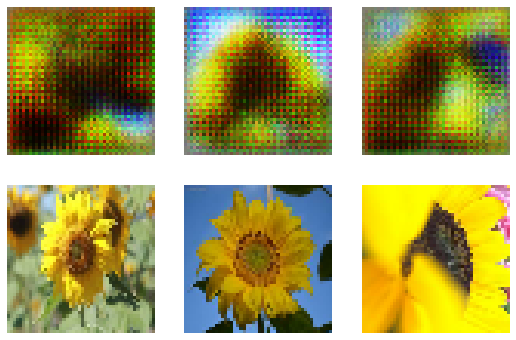

Epoch 2/100
[[460 567]
 [180 847]]
accuracy:  0.6363193768257059
Epoch 3/100
[[548 479]
 [203 824]]
accuracy:  0.667964946445959
Epoch 4/100
[[565 462]
 [204 823]]
accuracy:  0.6757546251217137
Epoch 5/100
[[531 496]
 [198 829]]
accuracy:  0.6621226874391432
Epoch 6/100

2022-06-02 03:00:29.764340: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


[[562 465]
 [197 830]]
accuracy:  0.6777020447906524
Epoch 7/100
[[396 631]
 [105 922]]
accuracy:  0.6416747809152873
Epoch 8/100
[[558 469]
 [189 838]]
accuracy:  0.6796494644595911
Epoch 9/100
[[630 397]
 [236 791]]
accuracy:  0.6918208373904576
Epoch 10/100


2022-06-02 03:00:42.657030: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-06-02 03:00:42.717247: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


[[688 339]
 [209 818]]
accuracy:  0.7332035053554041
Epoch 11/100
[[753 274]
 [243 784]]
accuracy:  0.7482960077896786
Epoch 12/100
[[700 327]
 [254 773]]
accuracy:  0.7171372930866602
Epoch 13/100
[[750 277]
 [269 758]]
accuracy:  0.7341772151898734
Epoch 14/100
[[780 247]
 [309 718]]
accuracy:  0.7293086660175268
Epoch 15/100
[[756 271]
 [282 745]]
accuracy:  0.7307692307692307
Epoch 16/100
[[763 264]
 [219 808]]
accuracy:  0.7648490749756572
Epoch 17/100
[[790 237]
 [268 759]]
accuracy:  0.7541382667964946
Epoch 18/100
[[835 192]
 [274 753]]
accuracy:  0.7731256085686465
Epoch 19/100
[[761 266]
 [322 705]]
accuracy:  0.7137293086660176
Epoch 20/100
[[779 248]
 [231 796]]
accuracy:  0.7667964946445959
Epoch 21/100
[[810 217]
 [297 730]]
accuracy:  0.7497565725413826
Epoch 22/100
[[799 228]
 [244 783]]
accuracy:  0.7702044790652386
Epoch 23/100
[[838 189]
 [235 792]]
accuracy:  0.7935735150925024
Epoch 24/100
[[848 179]
 [275 752]]
accuracy:  0.7789678675754625
Epoch 25/100
[[832 195]

2022-06-02 03:01:47.143245: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


[[834 193]
 [189 838]]
accuracy:  0.8140214216163584
Epoch 29/100
[[857 170]
 [207 820]]
accuracy:  0.8164556962025317
Epoch 30/100
[[846 181]
 [232 795]]
accuracy:  0.7989289191820838
Epoch 31/100
[[872 155]
 [186 841]]
accuracy:  0.8339824732229796
Epoch 32/100
[[844 183]
 [221 806]]
accuracy:  0.8033106134371957
Epoch 33/100
[[884 143]
 [168 859]]
accuracy:  0.8485881207400194
Epoch 34/100

2022-06-02 03:02:08.614233: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


==

2022-06-02 03:02:08.892253: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


[[836 191]
 [250 777]]
accuracy:  0.7852969814995131
Epoch 35/100
[[878 149]
 [156 871]]
accuracy:  0.8515092502434275
Epoch 36/100
[[874 153]
 [174 853]]
accuracy:  0.8407984420642648
Epoch 37/100
[[848 179]
 [167 860]]
accuracy:  0.8315481986368062
Epoch 38/100
[[877 150]
 [172 855]]
accuracy:  0.8432327166504382
Epoch 39/100
[[893 134]
 [166 861]]
accuracy:  0.8539435248296008
Epoch 40/100
[[877 150]
 [195 832]]
accuracy:  0.832035053554041
Epoch 41/100
[[932  95]
 [139 888]]
accuracy:  0.8860759493670886
Epoch 42/100
[[911 116]
 [168 859]]
accuracy:  0.8617332035053554
Epoch 43/100
[[900 127]
 [171 856]]
accuracy:  0.8549172346640701
Epoch 44/100
[[908 119]
 [121 906]]
accuracy:  0.8831548198636806
Epoch 45/100
[[907 120]
 [154 873]]
accuracy:  0.866601752677702
Epoch 46/100
[[934  93]
 [125 902]]
accuracy:  0.8938656280428432
Epoch 47/100
[[916 111]
 [142 885]]
accuracy:  0.8768257059396299
Epoch 48/100
[[920 107]
 [137 890]]
accuracy:  0.881207400194742
Epoch 49/100
[[923 104]
 [

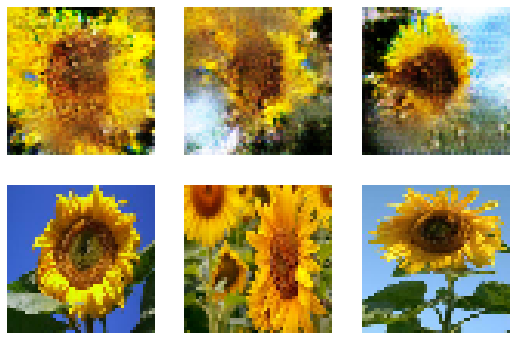

Epoch 52/100
[[879 148]
 [123 904]]
accuracy:  0.868062317429406
Epoch 53/100
[[948  79]
 [ 92 935]]
accuracy:  0.9167478091528725
Epoch 54/100
[[923 104]
 [103 924]]
accuracy:  0.8992210321324245
Epoch 55/100
[[933  94]
 [ 65 962]]


2022-06-02 03:03:25.774476: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


accuracy:  0.9225900681596884
Epoch 56/100
[[924 103]
 [ 96 931]]
accuracy:  0.9031158714703018
Epoch 57/100
[[945  82]
 [110 917]]
accuracy:  0.9065238558909445
Epoch 58/100
[[961  66]
 [ 82 945]]
accuracy:  0.9279454722492697
Epoch 59/100
[[910 117]
 [111 916]]
accuracy:  0.8889970788704966
Epoch 60/100
[[954  73]
 [ 63 964]]
accuracy:  0.9337877312560857
Epoch 61/100
[[911 116]
 [ 99 928]]
accuracy:  0.8953261927945472
Epoch 62/100
[[964  63]
 [ 61 966]]
accuracy:  0.9396299902629016
Epoch 63/100
[[928  99]
 [ 70 957]]
accuracy:  0.9177215189873418
Epoch 64/100
[[961  66]
 [ 58 969]]
accuracy:  0.9396299902629016
Epoch 65/100
[[959  68]
 [ 55 972]]
accuracy:  0.9401168451801363
Epoch 66/100
[[954  73]
 [ 71 956]]
accuracy:  0.9298928919182083
Epoch 67/100
[[963  64]
 [ 65 962]]
accuracy:  0.9371957156767283
Epoch 68/100
[[950  77]
 [ 66 961]]
accuracy:  0.930379746835443
Epoch 69/100
[[962  65]
 [ 82 945]]
accuracy:  0.9284323271665044
Epoch 70/100
[[944  83]
 [ 71 956]]
accuracy:  

2022-06-02 03:05:04.822720: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


[[976  51]
 [ 50 977]]
accuracy:  0.950827653359299
Epoch 84/100
[[ 978   49]
 [  27 1000]]
accuracy:  0.9629990262901655
Epoch 85/100
[[963  64]
 [ 28 999]]
accuracy:  0.9552093476144109
Epoch 86/100
[[970  57]
 [ 36 991]]
accuracy:  0.9547224926971762
Epoch 87/100
[[ 973   54]
 [  24 1003]]
accuracy:  0.9620253164556962
Epoch 88/100
[[995  32]
 [ 44 983]]
accuracy:  0.9629990262901655
Epoch 89/100
[[ 977   50]
 [  25 1002]]
accuracy:  0.9634858812074002
Epoch 90/100
[[949  78]
 [ 43 984]]
accuracy:  0.9410905550146057
Epoch 91/100
[[ 985   42]
 [  20 1007]]
accuracy:  0.9698149951314509
Epoch 92/100
[[ 996   31]
 [  19 1008]]
accuracy:  0.9756572541382668
Epoch 93/100
[[981  46]
 [ 39 988]]
accuracy:  0.9586173320350535
Epoch 94/100
[[977  50]
 [ 35 992]]
accuracy:  0.9586173320350535
Epoch 95/100
[[974  53]
 [ 33 994]]
accuracy:  0.9581304771178188
Epoch 96/100
[[975  52]
 [ 33 994]]
accuracy:  0.9586173320350535
Epoch 97/100
[[ 996   31]
 [  27 1000]]
accuracy:  0.9717624148003895


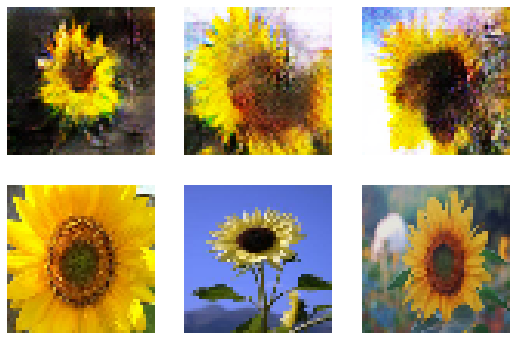

In [8]:
# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(42)

discriminator.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop())
discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop())

train_gan(gan, training_generator, BATCH_SIZE, ENCODING_SIZE, n_epochs = 100, plot_frequency = 50)

# Conclusions

In early epochs, the generator essentially learns the color palette first.  In some examples, depending on the size of the images, the depth of the network, etc., the first few epoch were clearly noise in the wrong color space, but would quickly change to the right set of yellows and reds.  Within a few more epochs, a color separation in the images with blue on top, yellow in the middle, and darker (generally greenish) on the bottom, showing that the generator was learing the general structure of the images.  This structure typically consisted of a central, yellow sunflower, framed on a blue sky and having dark green leaves on the bottom.  Along the way, more circular shapes would begin to emerge, and eventually some images that had some sunflower characteristics were produced.  Granted, these will not fool anyone, but there's clearly a learning process happening.

It was clear that larger images were much harder, and reducing the images to 48 x 48 helped.  Reducing the images further was helpful, but then the real images were themselves less convincing.  

Deeper network with 4 or 5 convolutional layers and as many as 1024 filters in the deepest layer also improved the images, but only slightly.

Clear limitations of this approach include:
* there were only 1027 images in the real image set
* the images were not very consistently framed - some have wonderfully centered flowers, but there are many camera angles, and many images of fields of sunflowers
* much larger and more complex networks might help, but more training data will probably be more impactful

Also interesting is the periodicity observed in the generated images.  There are repeated pattern blocks that are clearly reflective of the underlying network structure and weights.  I'm quite surprised at the degree of periodicity, however.  A more thorough investigation of the weights of each layer of the network would be interesting to determine why there are such periodic or symmetric structures.